In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as mg

import seaborn as sns
from matplotlib.patches import Patch
from PIL import Image
from scipy.stats import median_abs_deviation, wilcoxon, ttest_rel

plt.rcParams.update({
    "font.size": 9,
    "axes.titlesize": 11,
    "axes.labelsize": 10,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "figure.dpi": 150
})
sns.set_style("white")

In [3]:
# Epigept vs Corgi results (assay-level long table)
epigept_vs_corgi_path = "/project/deeprna_data/epigept/corgi_benchmark/results2.csv"

# Corgi vs Borzoi results (long table)
borzoi_vs_corgi_path = "/project/deeprna_data/benchmark/grt_vs_borzoi/correlation_results.csv"

# IGV image path for panel (e)
igv_image_path = None  # set to "/path/to/igv.png" when available

# load
df_epigept = pd.read_csv(epigept_vs_corgi_path)
df_borzoi = pd.read_csv(borzoi_vs_corgi_path)

In [4]:
MODEL_COLORS = {
    'Corgi': '#f28e2b',    # orange
    'EpiGePT': '#4e79a7',  # muted blue
    'Borzoi': '#59a14f'    # green
}

def map_assay_names(x):
    s = str(x).strip().lower()
    if s == 'dnase': return 'DNase'
    if s == 'atac': return 'ATAC'
    if s == 'ctcf': return 'CTCF'
    if s.startswith('cage'): return 'CAGE'
    if 'rna' in s and not s.startswith('rna_10x'): return 'RNA'
    if len(s) > 0 and s[0] == 'h': return 'Histone'
    return None

In [5]:
def draw_violin(ax, df, models, metric, categories, palette):
    sns.violinplot(
        ax = ax,
        data = df,
        x = metric,
        y = 'assay_type',
        hue = 'model',
        split = True,
        inner = 'quart',
        cut = 0,
        width = 0.6,
        density_norm = 'width',
        order = categories,
        palette = palette,
    )
    data_min, data_max = ax.get_xlim()
    ax.legend_.remove()
    ax.set_xlim(left=0, right=1)

    for i, cat in enumerate(categories):
        df_cat = df[df['assay_type'] == cat].copy()
        n = len(df_cat.loc[df_cat['model'] == models[0], metric])
        left = df_cat.loc[df_cat['model'] == models[0], metric].values
        right = df_cat.loc[df_cat['model'] == models[1], metric].values
        mean_l = np.mean(left)
        mean_r = np.mean(right)
        stat, p_val = wilcoxon(left, right)

        y = i  # seaborn category positions
        ax.text(0.02, y - 0.35,
            f"{models[0]} μ={mean_l:.3f}",
            fontsize=7, va='center', ha='left', color=palette[models[0]])
        ax.text(0.02, y - 0.15,
            f"{models[1]} μ={mean_r:.3f}",
            fontsize=7, va='center', ha='left', color=palette[models[1]])

        if p_val > 0.05:
            ax.text(0.02, y+0.05, f"n={int(n)}", fontsize=6, va='center', ha='left', color='dimgray')
        elif p_val >= 0.001:
            ax.text(0.02, y+0.15, f"n={int(n)}\np={p_val:.3f}", fontsize=6, va='center', ha='left', color='dimgray')
        else:
            ax.text(0.02, y+0.15, f"n={int(n)}\np<0.001", fontsize=6, va='center', ha='left', color='dimgray')

In [8]:
df1 = df_epigept.copy()
if 'assay' not in df1.columns and 'experiment' in df1.columns:
    df1 = df1.rename(columns={'experiment': 'assay'})
df1['model'] = df1['model'].astype(str).replace({'corgi': 'Corgi', 'epigept': 'EpiGePT'})
df1['assay_raw'] = df1['assay'].astype(str)
df1['assay_type'] = df1['assay_raw'].apply(map_assay_names)
df1 = df1[df1['assay_type'].isin(['DNase', 'Histone', 'CTCF'])].copy()

df2 = df_borzoi.copy()
if 'assay' not in df2.columns and 'experiment' in df2.columns:
    df2 = df2.rename(columns={'experiment': 'assay'})
df2['model'] = df2['model'].astype(str).replace({'GRT': 'Corgi', 'grt': 'Corgi', 'borzoi': 'Borzoi'})
df2['assay_raw'] = df2['assay'].astype(str)
df2['assay_type'] = df2['assay_raw'].apply(map_assay_names)
allowed = ['DNase', 'ATAC', 'Histone', 'CTCF', 'CAGE', 'RNA']
df2 = df2[df2['assay_type'].isin(allowed)].copy()

In [166]:
figsize = (10,10)
dpi = 150
output_pdf = '/project/deeprna/figures/paper/figure3.pdf'
output_png = '/project/deeprna/figures/paper/figure3.png'

/scratch/local/ipykernel_68741/3792793536.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


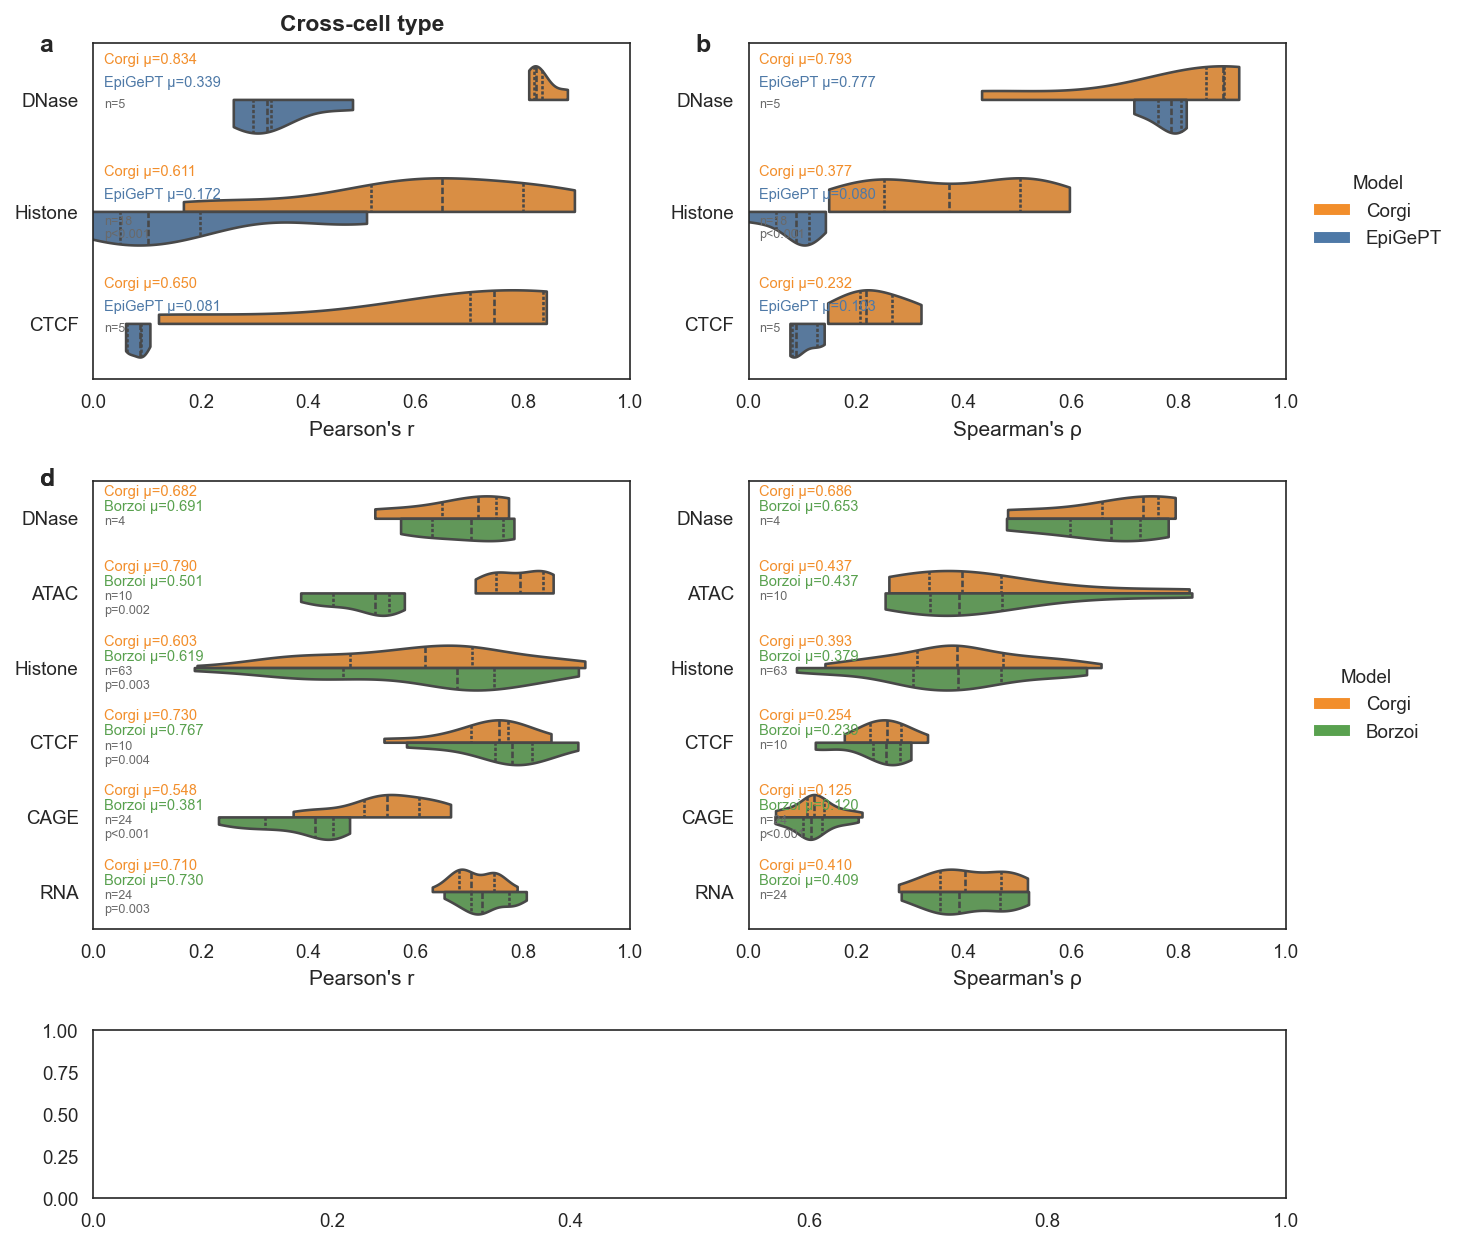

In [167]:
fig = plt.figure(figsize=figsize, dpi=dpi)
gs = fig.add_gridspec(nrows=3, ncols=2, height_ratios=[0.9, 1.2, 0.45], hspace=0.32, wspace=0.22)

ax_a = fig.add_subplot(gs[0, 0])  # Pearson Corgi vs EpiGePT
ax_b = fig.add_subplot(gs[0, 1])  # Spearman Corgi vs EpiGePT
ax_c = fig.add_subplot(gs[1, 0])  # Pearson Corgi vs Borzoi
ax_d = fig.add_subplot(gs[1, 1])  # Spearman Corgi vs Borzoi
ax_e = fig.add_subplot(gs[2, :])  # IGV

# ---- Panels a & b (Corgi vs EpiGePT) ----
draw_violin(ax_a, df1, ['Corgi', 'EpiGePT'], 'pearson', ['DNase', 'Histone', 'CTCF'], MODEL_COLORS)
ax_a.set_title("Cross-cell type", loc='center', fontsize=11, fontweight='semibold')
ax_a.set_xlabel("Pearson's r")
ax_a.set_ylabel("")
ax_a.text(-0.10, 1.03, 'a', transform=ax_a.transAxes, fontsize=12, fontweight='bold', va='top')

draw_violin(ax_b, df1, ['Corgi', 'EpiGePT'], 'spearman', ['DNase', 'Histone', 'CTCF'], MODEL_COLORS)
ax_b.text(-0.10, 1.03, 'b', transform=ax_b.transAxes, fontsize=12, fontweight='bold', va='top')
ax_b.set_xlabel("Spearman's ρ")
ax_b.set_ylabel("")

draw_violin(ax_c, df2, ['Corgi', 'Borzoi'], 'pearson', ['DNase', 'ATAC', 'Histone', 'CTCF', 'CAGE', 'RNA'], MODEL_COLORS)
ax_c.text(-0.10, 1.03, 'c', transform=ax_c.transAxes, fontsize=12, fontweight='bold', va='top')
ax_c.set_xlabel("Pearson's r")
ax_c.set_ylabel("")

draw_violin(ax_d, df2, ['Corgi', 'Borzoi'], 'spearman', ['DNase', 'ATAC', 'Histone', 'CTCF', 'CAGE', 'RNA'], MODEL_COLORS)
ax_d.text(-0.10, 1.03, 'd', transform=ax_c.transAxes, fontsize=12, fontweight='bold', va='top')
ax_d.set_xlabel("Spearman's ρ")
ax_d.set_ylabel("")


handles_ab = [Patch(facecolor=MODEL_COLORS['Corgi'], label='Corgi'),
              Patch(facecolor=MODEL_COLORS['EpiGePT'], label='EpiGePT')]
ax_b.legend(handles=handles_ab, title='Model', frameon=False, bbox_to_anchor=(1.02, 0.5), loc='center left', fontsize=9)

handles_cd = [Patch(facecolor=MODEL_COLORS['Corgi'], label='Corgi'),
              Patch(facecolor=MODEL_COLORS['Borzoi'], label='Borzoi')]
ax_d.legend(handles=handles_cd, title='Model', frameon=False, bbox_to_anchor=(1.02, 0.5), loc='center left', fontsize=9)

'''
# ---- Panel e: IGV ----
ax_e.set_title("IGV example", loc='center', fontsize=11, fontweight='semibold')
if igv_image_path is not None and os.path.exists(igv_image_path):
    img = Image.open(igv_image_path)
    ax_e.imshow(img)
    ax_e.axis('off')
else:
    ax_e.axis('off')

ax_e.text(-0.02, 1.02, 'e', transform=ax_e.transAxes, fontsize=12, fontweight='bold', va='top')
'''
# ---- finalize & save ----
plt.tight_layout()
plt.subplots_adjust(right=0.92)

if output_pdf:
    os.makedirs(os.path.dirname(output_pdf), exist_ok=True)
    fig.savefig(output_pdf, bbox_inches='tight', dpi=dpi)
if output_png:
    os.makedirs(os.path.dirname(output_png), exist_ok=True)
    fig.savefig(output_png, bbox_inches='tight', dpi=dpi)

In [9]:
df2.head()

,tissue,assay,model,pearson,spearman,assay_raw,assay_type
0,57,dnase,Corgi,0.692,0.794,dnase,DNase
1,57,dnase,Borzoi,0.783,0.781,dnase,DNase
2,57,h3k4me1,Corgi,0.604,0.581,h3k4me1,Histone
3,57,h3k4me1,Borzoi,0.698,0.625,h3k4me1,Histone
4,57,h3k4me2,Corgi,0.651,0.444,h3k4me2,Histone


In [ ]:
sns.violinplot(
        ax = ax,
        data = df,
        x = metric,
        y = 'assay_type',
        hue = 'model',
        split = True,
        inner = 'quart',
        cut = 0,
        width = 0.6,
        density_norm = 'width',
        order = categories,
        palette = palette,
    )

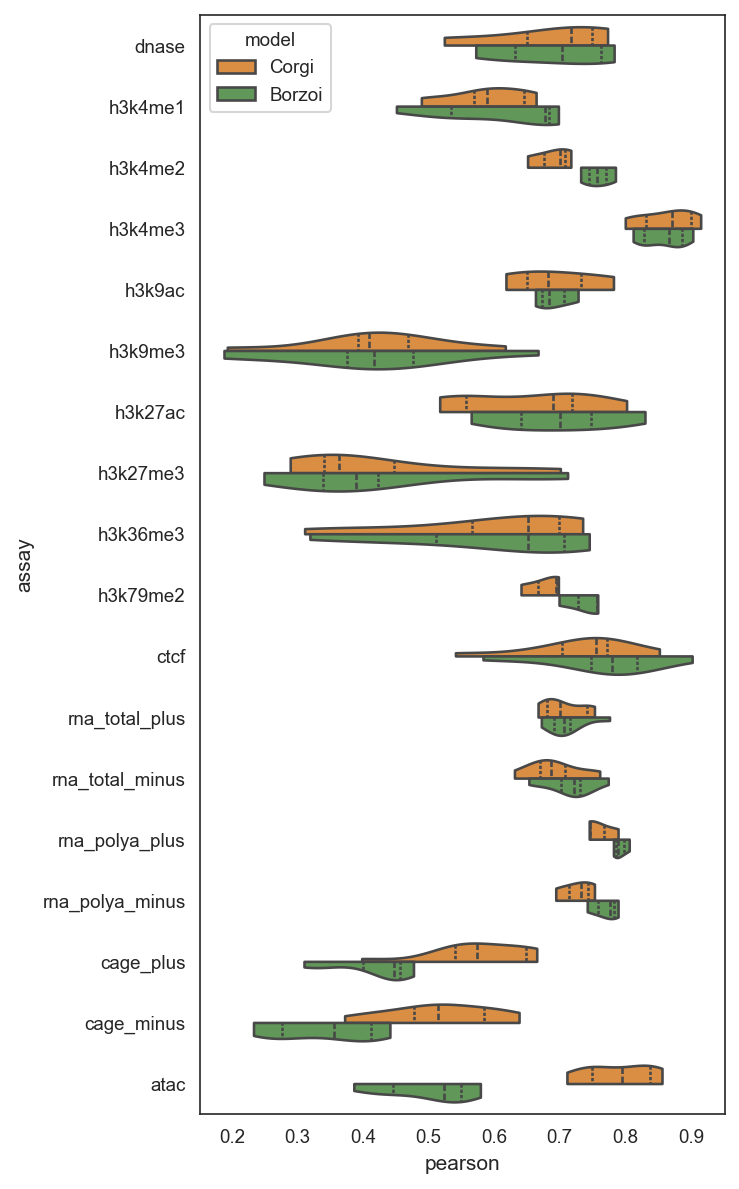

In [16]:
plt.figure(figsize=(5,8))
sns.violinplot(df2, x='pearson', y='assay', hue='model', split=True, inner='quart', cut=0, width=0.6, density_norm='width', palette=MODEL_COLORS)
plt.tight_layout()
plt.savefig('/project/deeprna/figures/paper/supplement/sup_7a.png', dpi=300)

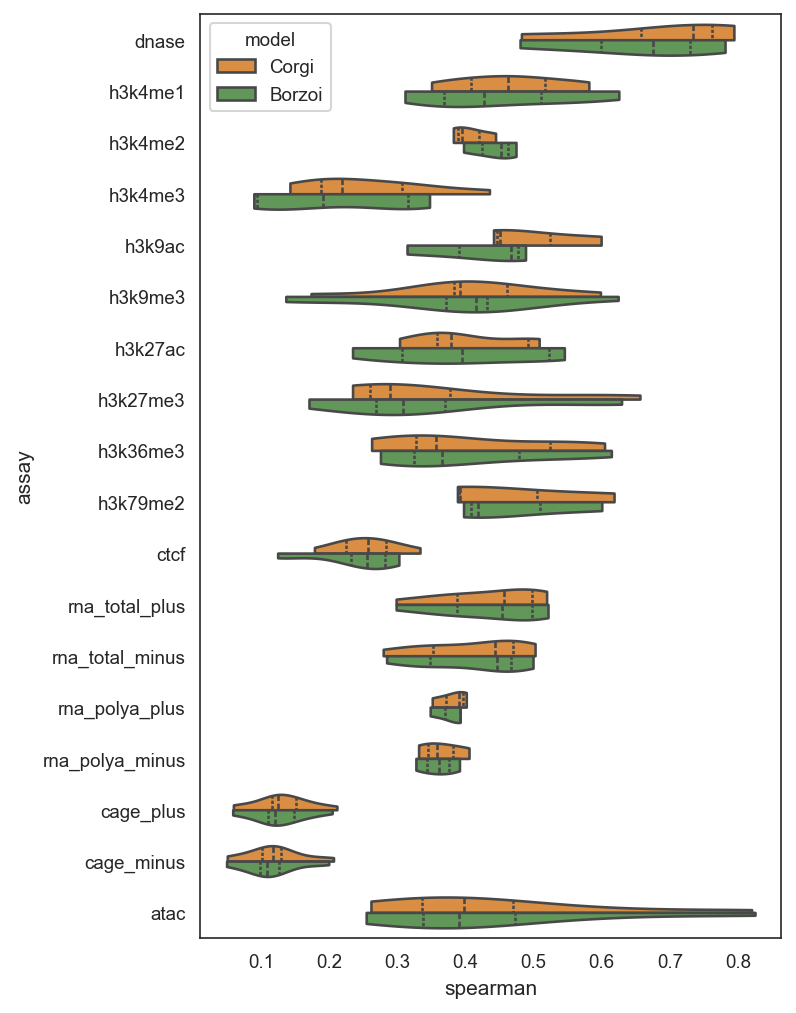

In [15]:
plt.figure(figsize=(5,8))
sns.violinplot(df2, x='spearman', y='assay', hue='model', split=True, inner='quart', cut=0, width=0.6, density_norm='width', palette=MODEL_COLORS)
plt.savefig('/project/deeprna/figures/paper/supplement/sup_7b.png', dpi=300)